# Identifying Confusion Amongst Python Programmers

An interactive introduction to data science workflows.

## Introduction

This is a Jupyter notebook.  It allows you to program interactively using both Python and Markdown (you can set individual cells of text to be either).  It has two modes: command mode and edit mode.  Hit `ESC` + `h` to see a Help menu.  `shift` + `enter` will run an individual cell.  You can run all cells immediately from both the Cell and Kernel sub-menus above.

## Today's Scenario

Harriet Human-Resources, the VP in charge of hiring and training, comes to you one day and says:

> We need to make our internal training programs for recent hires better.  We’re going to put a team on it, but they need more information how to teach them new languages. We want to focus on Python first.
   
   > I know you’re busy with 100 other things, but can you give us some preliminary insight at the end of the day?


## A Data Science Workflow

1. Define the question and goals.
2. Acquire the data.
3. Scrub the data.
4. Explore the data.
5. Model the Data (if predictions needed).
6. Communicate insights.
7. Repeat and Refine as necessary.

## Step 1: Define the question and goals.

--> **What aspects of Python programming present the most difficulties to programmers?**


## Step 2: Identify and Acquire the data.

Stack Overflow is the world's premier software Q&A site.

It organizes questions by topic tags.  One of these tags is "Python". There are almost one million questions on the Python tag: https://stackoverflow.com/questions/tagged/python.

For the purposes of today's exercise, we are going to pretend that Stack Overflow's API is insufficient for our needs.  Instead, we are going to scrape the data in HTML format.

You can do this using the Requests (as in HTTP) library. Requests provides a very simplistic API for making HTTP requests.

In order to rapidly prototype, let's acquire just the first 5 pages of Python questions.  An examination of the Stack Overflow web app shows that this information lives at the URLs that look like this:

https://stackoverflow.com/questions/tagged/python?page=5&sort=votes&pagesize=15

See the `page=5` and `pagesize=15` query parameters?  

Put all of this information together and use Python's built-in `open` function to scrape Stack Overflow's data to files in the `data/raw` diretory:

In [1]:
import requests

page_range = range(1, 6)
so_url = "https://stackoverflow.com/questions/tagged/python?page={0}&sort=votes&pagesize=15"
raw_file = 'data/raw/PAGE_{0}.html'

for page_number in page_range:
    response = requests.get(so_url.format(page_number))

    if response.status_code == 200:
        f = open(raw_file.format(page_number), 'w')
        f.write(response.text)  
        f.close()
    else:
        print("FAILED at {0} with status code {1}".format(page_number, response.status_code))

## Step 3: Clean/Wrangle the data.

Beautiful Soup is the most popular Python library for parsing HTML.  It parses HTML files into a tree-like Python data structure.

It works like this:

In [2]:
from bs4 import BeautifulSoup

with open('data/raw/PAGE_1.html', 'r') as f:
    soup = BeautifulSoup(f.read(), 'html.parser')
    page_title = soup.find_all("h1")
    print(page_title[0].text)


Tagged Questions


Look at the Stack Overflow Pythonpage and think about the information contained on that page: What are the granular data points we want to extract?  What is the top-level real-world object? 


Here, it is the question object.  Some of the attributes of a question object that you can see on the page are:
- question text
- vote score
- views 
- details
- author
- question details 
- date

Let's think about this question from the top-down.  We basically want each of these question attributes grouped together in an object.  For purposes of developing our initial data structure, we can parse out 250 question objects into an array.  We basically want to be able to write code that looks like this:

```
dataset = []

for i in page_range:
    filename = "data/raw/FILENAME_{}.html".format(i)
    qs = extract_question_objects(filename)
    dataset.extend(qs)
    
```

Let's write some supporting functions for this loop first:

In [3]:
def get_question_info_from_summary(summary_div):
    qid = summary_div['id'].split("-")[2]
    text = summary_div.find('a', class_="question-hyperlink").text
    tags = [tag.text for tag in summary_div.find_all('a', class_="post-tag")]
    views = int(summary_div.find('div', class_="views")['title'].split(" ")[0].replace(",", ""))
    votes = int(summary_div.find('span', class_="vote-count-post").find('strong').text)

    # data isn't always there
    date = summary_div.find('span', class_='relativetime')
    date_asked = date['title'] if date else None
    
    return [qid, views, text, tags, date_asked, votes]


def extract_question_objects(relative_html_path):
    questions_objects = []
    
    with open(relative_html_path, 'r') as f:
        soup = BeautifulSoup(f.read(), 'html.parser')
        
    question_divs = soup.find_all("div", class_="question-summary")
    
    for question in question_divs:
            q_info = get_question_info_from_summary(question)
            questions_objects.append(q_info)
    
    return questions_objects


Now let's run that top-down code:

In [4]:
dataset = []

for i in page_range:
    filename = "data/raw/PAGE_{}.html".format(i)
    qs = extract_question_objects(filename)
    dataset.extend(qs)

#  uncomment for fun
# print(len(dataset))
# print(dataset[0])

## Step 4: Explore the data.

One of the first things we want to do is get this data into a data structure known as a Pandas DataFrame.

Pandas is a Python package providing fast, flexible, and expressive data structures designed to make working with relational (“labeled”) data both easy and intuitive. It aims to be the fundamental high-level building block for doing practical, real world data analysis in Python. Additionally, it has the broader goal of becoming the most powerful and flexible open source data analysis /manipulation tool available in any language. It is well on its way toward this goal.

The `DataFrame` is  the primary Pandas data structure.  They are great for exploring about tabular data - think columns and rows.

In [5]:
import numpy as np
import pandas as pd

df = pd.DataFrame(columns=['views', 'text', 'tags', 'date_asked', 'votes'] )

for data in dataset:
    qid, views, text, tags, date_asked, votes = data
    df.loc[qid] = [views, text, tuple(np.array(tags)), date_asked, votes]


df


,views,text,tags,date_asked,votes
231767,1572191,What does the “yield” keyword do?,"(python, iterator, generator, yield, coroutine)",2008-10-23 22:21:11Z,7632
100003,559860,What are metaclasses in Python?,"(python, oop, metaclass, python-datamodel)",2008-09-19 06:10:46Z,4187
82831,2512917,How do I check whether a file exists using Pyt...,"(python, file, filesystems)",2008-09-17 12:55:00Z,3903
394809,1186861,Does Python have a ternary conditional operator?,"(python, operators, ternary-operator, conditio...",None,3897
419163,1488368,What does if __name__ == “__main__”: do?,"(python, module, namespaces, main, idioms)",2009-01-07 04:11:00Z,3539
89228,2295746,Calling an external command in Python,"(python, shell, command, subprocess, external)",2008-09-18 01:35:30Z,3242
38987,1005675,How to merge two dictionaries in a single expr...,"(python, python-3.x, dictionary, mapping, idioms)",2008-09-02 07:44:30Z,2814
613183,1581102,How do I sort a dictionary by value?,"(python, sorting, dictionary)",2009-03-05 00:49:05Z,2615
273192,1615028,How can I create a directory if it does not ex...,"(python, exception, directory)",2008-11-07 18:56:45Z,2609
3437059,2175779,Does Python have a string 'contains' substring...,"(python, string, substring, contains)",2010-08-09 02:52:50Z,2446


The Pandas DataFrame API is rich and worth exploring.

In [6]:
# uncomment line-by-line to explore:
# df['tags']
# df.columns
# df.index

### Exploratory Data Analaysis: Pandas Profiling

Pandas DataFrames have some built-in data profilings...

In [7]:
df.describe()

,views,text,tags,date_asked,votes
count,250,250,250,240,250
unique,250,250,221,240,211
top,200183,How do I remove/delete a folder that is not em...,"(python,)",2008-10-23 22:21:11Z,545
freq,1,1,10,1,4


....but the `pandas-profiling` package is more complete.  One of the first things many data scientists do is run a profile on their dataframe.  Let's do that here.

In [8]:
import pandas_profiling

pandas_profiling.ProfileReport(df)

Number of variables,6
Number of observations,250
Total Missing (%),0.7%
Total size in memory,11.8 KiB
Average record size in memory,48.3 B
Numeric,2
Categorical,2
Date,0
Text (Unique),2
Rejected,0
Distinct count,241


There are plenty of interesting things to notice here.

### Exploratory Data Analysis: Word Clouds

The real meat of the Stack Overflow data we have so far lay in question text.  Analyzing text is one aspect of _natural language processing_.  One of the first things many data scientists do to examine text data is make a word cloud, measuring the importance of words by their relative frequencies.

To get started with word clouds, we will use the Python `collections` library, most specifically its `Counter` data structure.  If you feed `Counter` an array of words, it will return a count of words frequencies.  Let's find the 100 most common words first.

#### Word Cloud 1: The 100 Most Common Words With `collections.Counter`

In [9]:
from collections import Counter

SO_words = []

for i, row in df.iterrows():
     words = row.text.split(" ")
     for word in words:
        SO_words.append(word)

so_counter = Counter([word for word in SO_words])
most_common = so_counter.most_common(100)

print(most_common)

[('in', 119), ('a', 113), ('How', 89), ('Python', 78), ('to', 75), ('Python?', 49), ('the', 47), ('I', 44), ('do', 42), ('of', 41), ('is', 31), ('and', 26), ('What', 23), ('list', 22), ('with', 20), ('from', 20), ('an', 19), ('string', 19), ('can', 14), ('if', 12), ('between', 12), ('way', 12), ('does', 10), ('file', 10), ('get', 10), ('or', 10), ('Why', 10), ('check', 9), ('not', 9), ('[closed]', 9), ('using', 8), ('on', 8), ('[duplicate]', 8), ('you', 8), ('for', 8), ('are', 7), ('dictionary', 7), ('by', 7), ('directory', 7), ('pip', 7), ('lists', 7), ('Is', 7), ('there', 7), ('python', 7), ('two', 6), ('difference', 6), ('line', 6), ('remove', 6), ('use', 6), ('create', 5), ('it', 5), ('function', 5), ('install', 5), ("Python's", 5), ('variable', 5), ('over', 5), ('into', 5), ('values', 5), ('print', 5), ('file?', 5), ('object', 5), ('pandas', 5), ('sort', 4), ('all', 4), ('vs.', 4), ('multiple', 4), ('time', 4), ('current', 4), ('dictionary?', 4), ('Getting', 4), ('module', 4), ('D

Let's visualize this with a wordcloud, measuring by frequency.  We will use two libraries, `matplotlib` and `wordcloud`.

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [11]:
## Newer versions of WordCloud (which you're likely to have if you manually installed the
## packages rather than using the spec file) expect a dictionary mapping words to frequencies 
## (i.e. strings to floats).  You can uncomment the following line of code if this is the case
## for you.  

# most_common = {word: frequency for word, frequency in most_common}


Making the word cloud is easy:

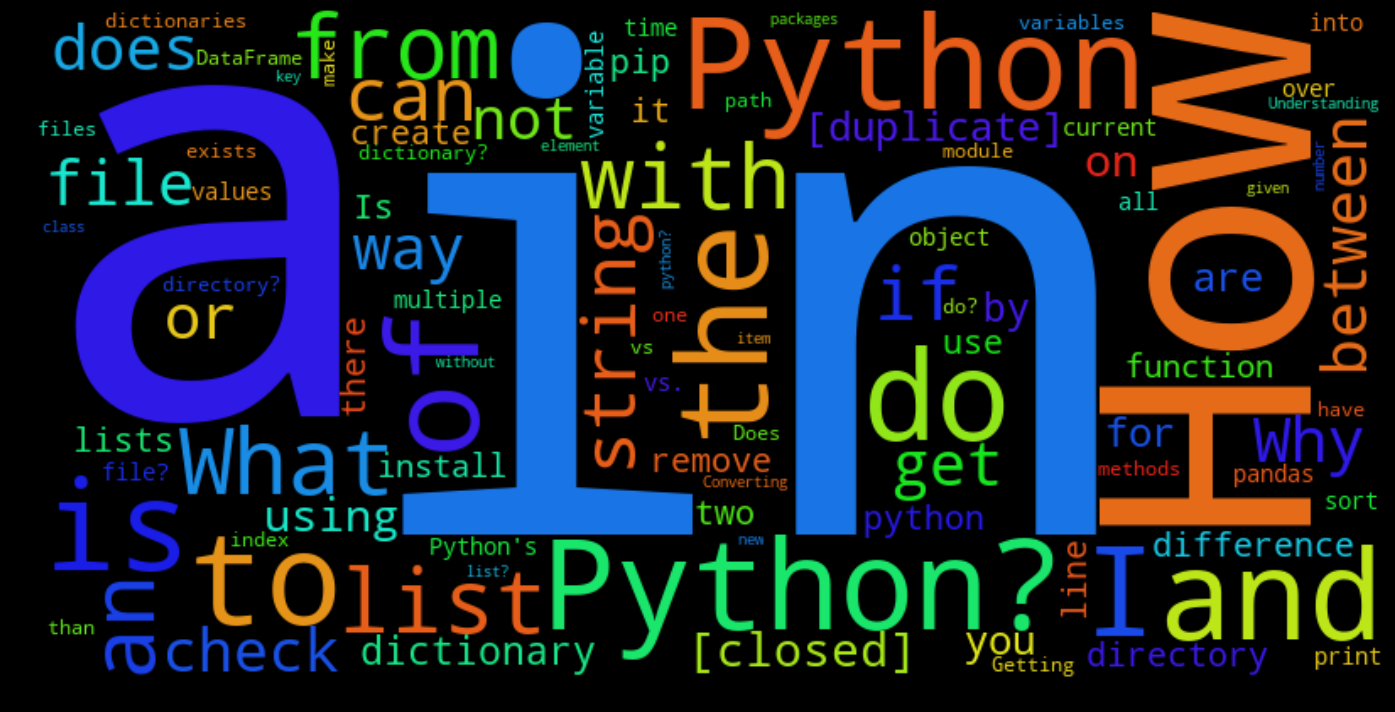

In [12]:
wordcloud = WordCloud(width=800, height=400)
wordcloud.generate_from_frequencies(frequencies=most_common)
plt.figure(figsize=(20,10), facecolor='k')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout()
# plt.savefig('wordcloud.png')
plt.show()

This looks like hot garbage.   

Let's use a list of **stop words** as a filter when we're compiling our count.

#### Word Cloud #2: Removing Stop Words



In [13]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = set(stopwords.words('english'))

# print(stop)

[nltk_data] Downloading package stopwords to /Users/kevmo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
so_words = [word for word in SO_words if word.lower() not in stop]
so_counter = Counter(so_words)
most_common = so_counter.most_common(100)

# print(most_common)

Run the same visualization code to see if this is any better.

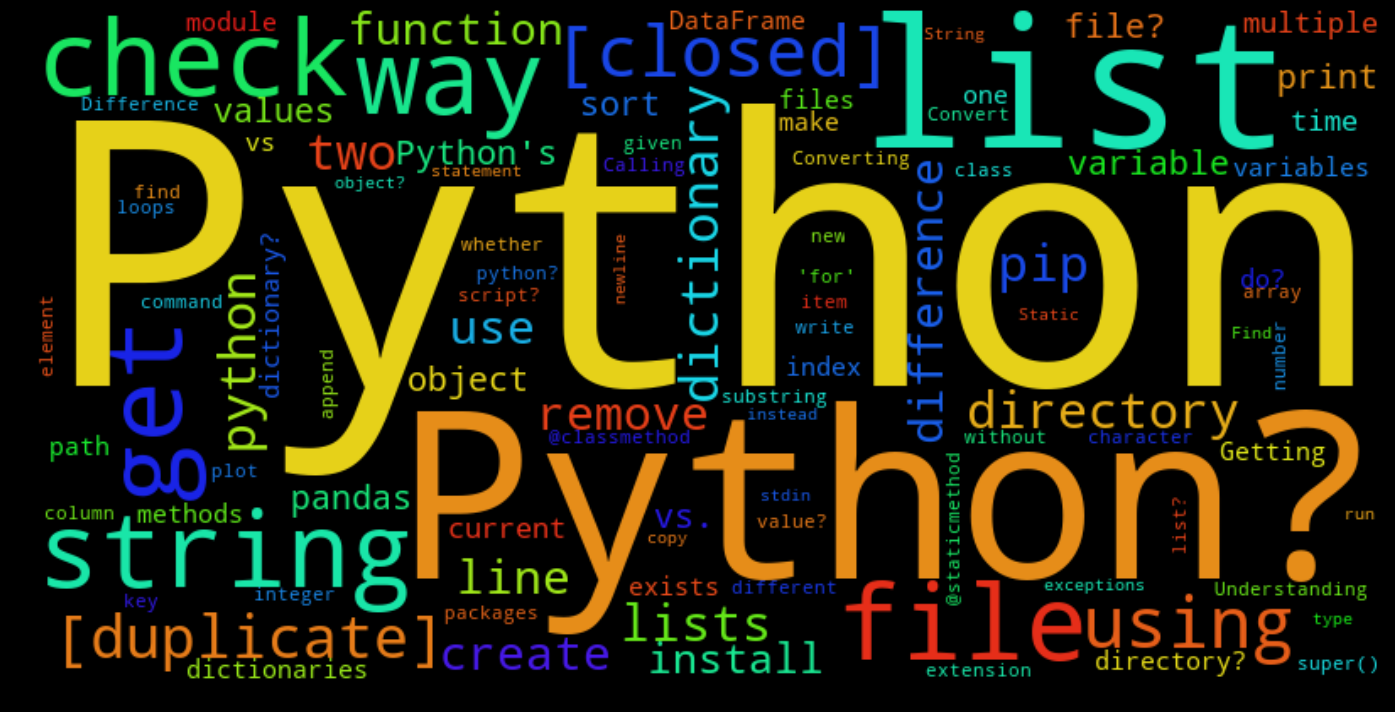

In [15]:
wordcloud = WordCloud(width=800, height=400)
wordcloud.generate_from_frequencies(frequencies=most_common)
plt.figure(figsize=(20,10), facecolor='k')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout()
# plt.savefig('wordcloud.png')
plt.show()

This is getting better.  

Now we can bring in **subject-matter expertise** (AKA **domain expertise**) and filter for the most relevant Python stuff.

#### Word Cloud #3: You are the Python and Stack Overflow subject-matter expert.

Build on `nltk`'s list of stop words.  Filter out the non-helpful and trivially helpful stuff:

In [16]:
SO_stopwords = [
    'python', 
    'python?', 
    'using',
    'how',
    'what',
    'why',
    'how',
    'way',
    '[closed]',
    '[duplicate]',
]

Python_stopwords = set(stopwords.words('english') + SO_stopwords)

# print(Python_stopwords)

OK, run the code again:

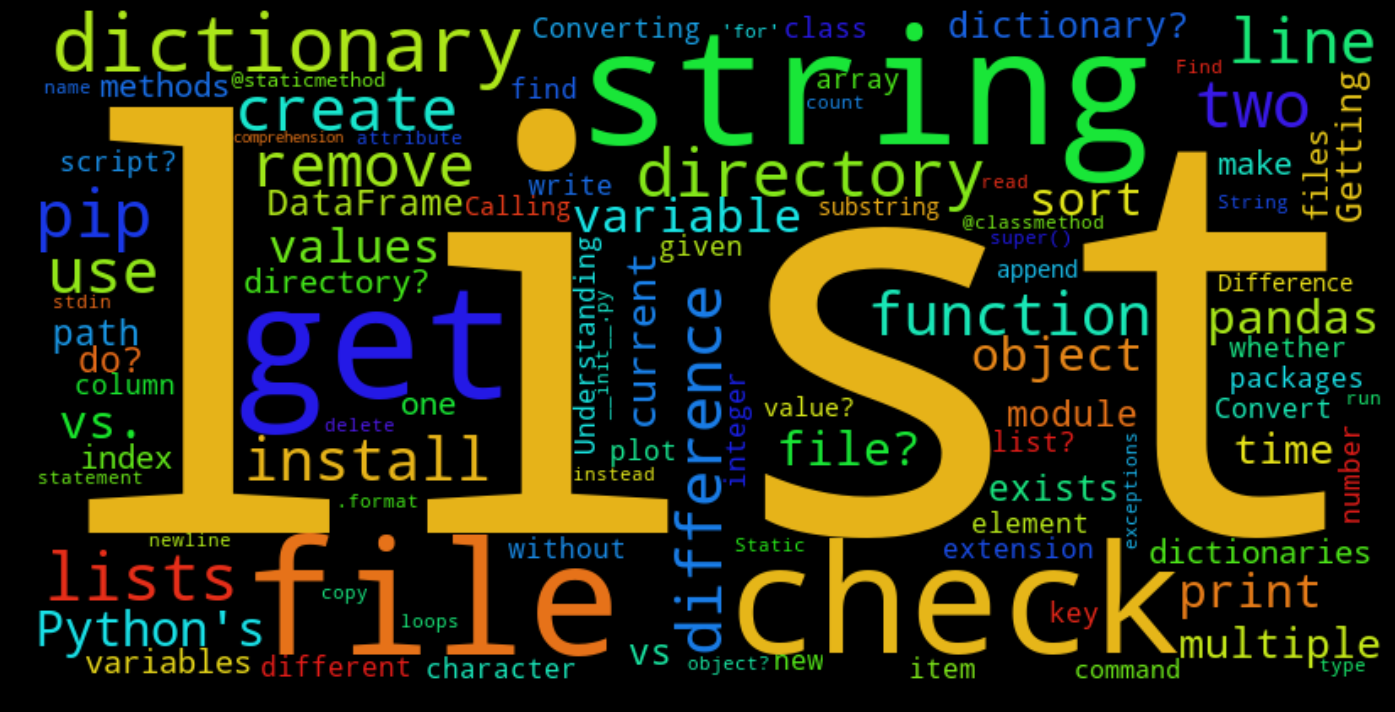

In [17]:
so_counter = Counter([word for word in SO_words if word.lower() not in Python_stopwords])

most_common = so_counter.most_common(100)

wordcloud = WordCloud(width=800, height=400)
wordcloud.generate_from_frequencies(frequencies=most_common)
plt.figure(figsize=(20,10), facecolor='k')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout()
plt.show()


Looking better! I see Pandas and DataFrames in there... speaking of: let's try getting more information into this word cloud by weighting these words with something less crude than sheer word frequency.

#### Word Cloud #4: Split-Apply-Combine With Pandas

Votes and views numbers are available for this data.  Let's weight each word by an aggregate score of `views + votes` instead of just word frequency.  Since we're just exploring, let's slice and aggregate this data into a new DataFrame:

In [18]:
df_words = pd.DataFrame(columns=['word', 'score'])

# Use X as an auto-ID incrementer
x = -1
 
for i, row in df.iterrows():
    words = row.text.split(" ")
    score = float(row.views) + float(row.votes)
    for word in words:
        if word.lower() not in Python_stopwords:
            x = x + 1 
            df_words.loc[x] = [word, score]

df_words

,word,score
0,“yield”,1579823.0
1,keyword,1579823.0
2,do?,1579823.0
3,metaclasses,564047.0
4,check,2516820.0
5,whether,2516820.0
6,file,2516820.0
7,exists,2516820.0
8,ternary,1190758.0
9,conditional,1190758.0


Now we will use a technique known as split-apply-combine to aggreggate all the same words together and combine their scores.

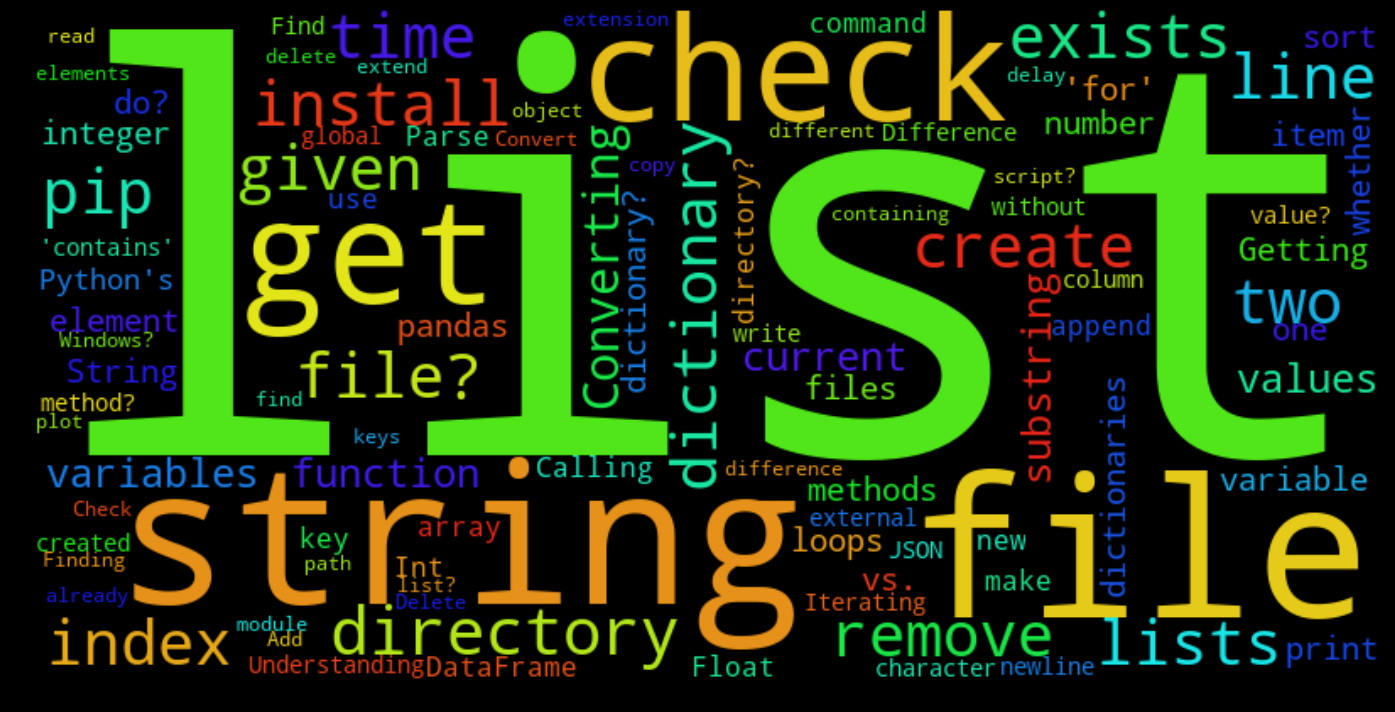

In [19]:
grouped_by_word = df_words.groupby('word')
scores = grouped_by_word.agg('sum')

top_100 = scores.sort_values('score')[-100:]
frequencies = [(i, word.score)  for i, word in top_100.iterrows()]

wordcloud = WordCloud(width=800, height=400)
wordcloud.generate_from_frequencies(frequencies=frequencies)
plt.figure(figsize=(20,10), facecolor='k')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout()
# plt.savefig('wordcloud.png')
plt.show()



Not bad!  What other improvements could we make?  Not just improving the code, but how could we extract and communicate more information from this?

### BONUS Exploratory Data Analysis: Tag Networks

Now let's get the 50 most popular question tags that aren't Python and see how they relate to one another.

whoo


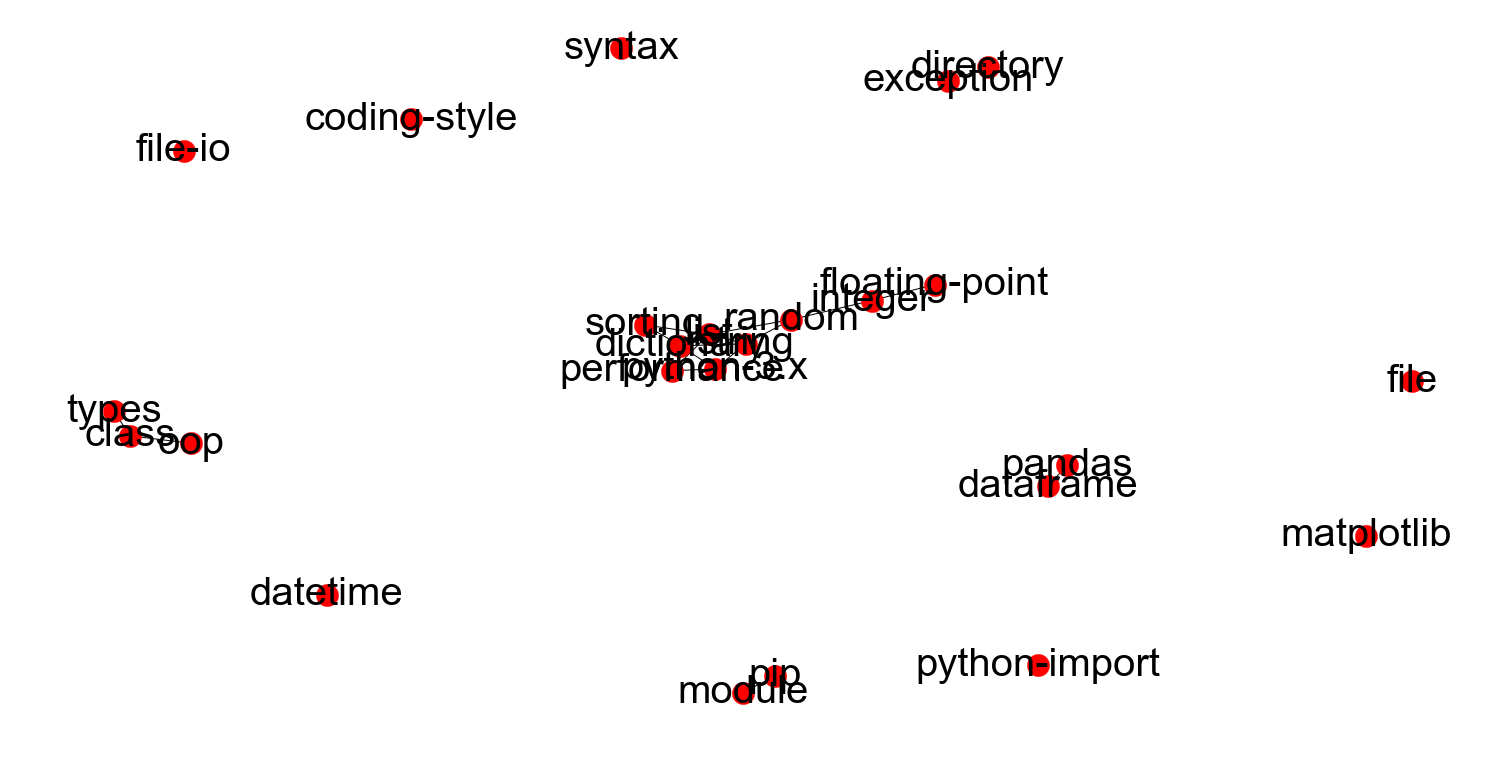

In [20]:
import networkx as nx

G = nx.Graph()


# Get the 50 most popular tags to use as a filter

all_tags = []

row_tags = [row.tags for i, row in df.iterrows()]

for tags in row_tags:
    for tag in tags:
        if tag != 'python':
            all_tags.append(tag)

top_25_tuples = Counter(all_tags).most_common(25)

top_25 = []
for tag, count in top_25_tuples:
    top_25.append(tag)

top_25

if 'list' in top_25:
    print('whoo')


# # # # # # # #
    
import itertools

# # slice off the Python in each one of these
tags = [row.tags[1:] for i, row in df.iterrows()]

x = 0

for question_tags in tags:
    for tag in question_tags:
        if tag in top_25:
            G.add_node(tag)

    for tag1, tag2 in itertools.combinations(question_tags, 2):
        if tag1 not in top_25 or tag2 not in top_25:
            break
        else: 
            G.add_edge(tag1, tag2)

    x = x + 1

plt.figure(figsize=(20,10))
nx.draw(G, with_labels=True, font_size=40, node_size=500, scale=4)


Not looking so good... but our meeting is coming up!

## Step 5: Model the data if preditions are needed.

We are not predicting anything today. 🌞

## Step 6: Communicate insights.

At this point, we are pretty ready to walk into our end-of-day meeting.  As John Tukey said, exploratory data analysis is an attitude.  Our attitude has now shifted to "I have a same-day meeting to deliver some insight."  At this point, you are prepared with:

* A profile of Stack Overflow question fields, which gives business intelligence about what sort of data is readily available;
* A word cloud that anybody can understand (visualization #1)
* A network graph visualization of related topics Python programmers have quesitons about (visualization #2) 
* A Jupyter notebook full of replicable code to be iterated and improved upon.

## Additional Challenges

0. Create reusable functions from the code in this notebook.  This would make the notebook a much stronger resource for your company.
1. Play with the final visualization (the tag network graph) to make it a better visualization.
2. Organize the original data into multiple DataFrames -- start by making tags its own DataFrame.
3. Find new ways to apply the split-apply-combine paradigm to this data.
4. What information did we not scrape from the questions page?  Go scrape that data.
5. Scrape the individual questions pages - the answers contain a tremendous amount of data as well!